In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
COIN_BLOCK_INFO_PATH = "coin_block_info"

coin = "SPD"
coin_per_block = 15
our_nethash = 540

fname = os.path.join(COIN_BLOCK_INFO_PATH, coin+"_block_info.csv")

In [3]:
df = pd.read_csv(fname)

In [4]:
df['date'] = pd.to_datetime(df['time'],unit='s')

In [5]:
print("Number of Blocks: {}".format(df.count()[0]))

Number of Blocks: 2000


In [6]:
print("Latest Block: {}".format(int(df["height"][0])))

Latest Block: 151770


In [7]:
COIN_NETHASH_INFO_PATH = "coin_nethash_info"
fname = os.path.join(COIN_NETHASH_INFO_PATH, coin+"_nethash_info.csv")

In [8]:
df_nethash = pd.read_csv(fname)

In [9]:
df = pd.merge(df, df_nethash, how='inner', on='height')

In [10]:
df.head(5)

,difficulty,flags,height,nonce,time,date,nethash
0,2736.491655,proof-of-work,151770,9.774225e+08,1.525696e+09,2018-05-07 12:33:33,117531
1,2341.219577,proof-of-work,151769,1.752632e+09,1.525696e+09,2018-05-07 12:29:42,103664
2,5194.036167,proof-of-work,151768,2.600152e+09,1.525696e+09,2018-05-07 12:28:51,225335
3,102660.430251,proof-of-stake,151767,0.000000e+00,1.525696e+09,2018-05-07 12:28:00,369967
4,80606.992230,proof-of-stake stake-modifier,151766,0.000000e+00,1.525696e+09,2018-05-07 12:28:32,369967


In [11]:
df_type = df.groupby("flags").size().reset_index(name='counts')
df_type["percentage"]=df_type["counts"]/sum(df_type["counts"])
df_type

,flags,counts,percentage
0,proof-of-stake,547,0.504613
1,proof-of-stake stake-modifier,195,0.179889
2,proof-of-work,256,0.236162
3,proof-of-work stake-modifier,86,0.079336


In [12]:
df_pow_block_rate = df[['flags','height','time', 'nethash']][df['flags'].str.contains("proof-of-work")].reset_index()
df_pow_block_rate.head(10)

,index,flags,height,time,nethash
0,0,proof-of-work,151770,1.525696e+09,117531
1,1,proof-of-work,151769,1.525696e+09,103664
2,2,proof-of-work,151768,1.525696e+09,225335
3,8,proof-of-work stake-modifier,151762,1.525696e+09,369967
4,9,proof-of-work,151761,1.525695e+09,287751
5,10,proof-of-work,151760,1.525695e+09,219819
6,12,proof-of-work stake-modifier,151758,1.525695e+09,230116
7,15,proof-of-work stake-modifier,151755,1.525695e+09,169604
8,18,proof-of-work,151751,1.525695e+09,219704
9,24,proof-of-work stake-modifier,151743,1.525695e+09,234639


In [13]:
height_MA_window = min(400, int((df_pow_block_rate.count()[0]-1)*0.5))
print("Block Height MA Windows = {}".format(height_MA_window))

nethash_MA_window = 50
print("Nethash MA Windows = {}".format(nethash_MA_window))

Block Height MA Windows = 170
Nethash MA Windows = 50


In [14]:
df_pow_count = df_pow_block_rate.count()[0]
print("Num of POW = {}".format(df_pow_count))

Num of POW = 342


In [15]:
df_pow_block_rate['pow_index'] = pd.DataFrame(range(df_pow_count)[::-1])
df_pow_block_rate.tail(5)

,index,flags,height,time,nethash,pow_index
337,1073,proof-of-work stake-modifier,149723,1.525622e+09,191023,4
338,1076,proof-of-work stake-modifier,149720,1.525621e+09,220705,3
339,1078,proof-of-work,149718,1.525621e+09,429148,2
340,1082,proof-of-work stake-modifier,149712,1.525621e+09,361259,1
341,1083,proof-of-work,149711,1.525621e+09,268904,0


In [16]:
df_pow_block_rate_window = df_pow_block_rate[["time", "pow_index"]].diff(-height_MA_window)
df_pow_block_rate_window_row_count = int(df_pow_block_rate_window.count()[0])
df_pow_block_rate_window['block_per_day']=df_pow_block_rate_window['pow_index']/df_pow_block_rate_window['time']*3600*24
print("Number of Rows in POW Height MA = {}".format(df_pow_block_rate_window_row_count))
df_pow_block_rate_window.head(8)

Number of Rows in POW Height MA = 172


,time,pow_index,block_per_day
0,45707.0,170.0,321.351215
1,45568.0,170.0,322.331461
2,45581.0,170.0,322.239530
3,45393.0,170.0,323.574119
4,45414.0,170.0,323.424495
5,45556.0,170.0,322.416367
6,45917.0,170.0,319.881525
7,45949.0,170.0,319.658752


In [17]:
df_nethash_MA = df_pow_block_rate[["nethash"]].rolling(window=5).mean()
df_nethash_MA_row_count = int(df_nethash_MA.count()[0])
print("Number of Rows in Nethash MA = {}".format(df_nethash_MA_row_count))
df_nethash_MA.head(8)

Number of Rows in Nethash MA = 338


,nethash
0,NaN
1,NaN
2,NaN
3,NaN
4,220849.6
5,241307.2
6,266597.6
7,255451.4


In [18]:
df_pow_block_rate_full = pd.concat([df_pow_block_rate_window, df_nethash_MA, df["height"]],axis=1)
df_pow_block_rate_full_row_count = df_pow_block_rate_full.count()[0]
print(df_pow_block_rate_full_row_count)
df_pow_block_rate_full = df_pow_block_rate_full.dropna()
df_pow_block_rate_full.head(5)

172


,time,pow_index,block_per_day,nethash,height
4,45414.0,170.0,323.424495,220849.6,151766
5,45556.0,170.0,322.416367,241307.2,151765
6,45917.0,170.0,319.881525,266597.6,151764
7,45949.0,170.0,319.658752,255451.4,151763
8,45948.0,170.0,319.665709,225398.8,151762


In [19]:
df_pow_nethash_block_profit = df_pow_block_rate_full
df_pow_nethash_block_profit["profit"] = df_pow_block_rate_full["block_per_day"]*our_nethash/df_pow_block_rate_full["nethash"]*coin_per_block
df_pow_nethash_block_profit.head(5)

,time,pow_index,block_per_day,nethash,height,profit
4,45414.0,170.0,323.424495,220849.6,151766,11.862093
5,45556.0,170.0,322.416367,241307.2,151765,10.822605
6,45917.0,170.0,319.881525,266597.6,151764,9.718919
7,45949.0,170.0,319.658752,255451.4,151763,10.135924
8,45948.0,170.0,319.665709,225398.8,151762,11.487604


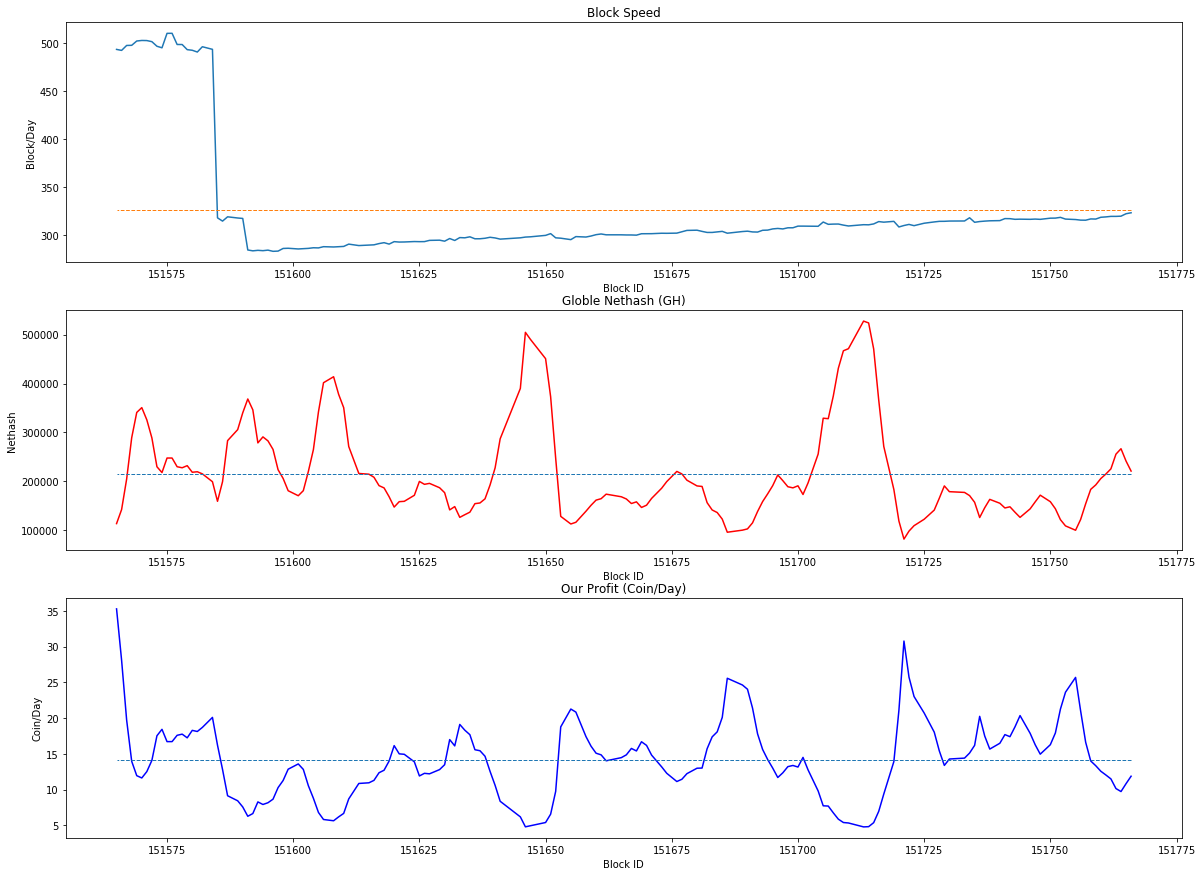

In [20]:
fig = plt.figure(figsize=(20,15))
plt.subplot(3, 1, 1)
plt.plot(df_pow_nethash_block_profit['height'], df_pow_nethash_block_profit['block_per_day'])
plt.plot(df_pow_nethash_block_profit['height'], 
         [np.mean(df_pow_nethash_block_profit['block_per_day'])]*df_pow_nethash_block_profit['height'].count(), 
         linestyle = '--', linewidth = 1)

plt.title('Block Speed')
plt.xlabel('Block ID')
plt.ylabel('Block/Day')

plt.subplot(3, 1, 2)
plt.plot(df_pow_nethash_block_profit['height'], df_pow_nethash_block_profit['nethash'], color='red')
plt.plot(df_pow_nethash_block_profit['height'], 
         [np.mean(df_pow_nethash_block_profit['nethash'])]*df_pow_nethash_block_profit['height'].count(), 
         linestyle = '--', linewidth = 1)
plt.title('Globle Nethash (GH)')
plt.xlabel('Block ID')
plt.ylabel('Nethash')

plt.subplot(3, 1, 3)
plt.plot(df_pow_nethash_block_profit['height'], df_pow_nethash_block_profit['profit'], color='blue')
plt.plot(df_pow_nethash_block_profit['height'], 
         [np.mean(df_pow_nethash_block_profit['profit'])]*df_pow_nethash_block_profit['height'].count(), 
         linestyle = '--', linewidth = 1)
plt.title('Our Profit (Coin/Day)')
plt.xlabel('Block ID')
plt.ylabel('Coin/Day')

plt.show()
